# Epymorph dev log: May 4th, 2023

_author: Tyler Coles_

_as of git hash: e68975b8abfde0f9e02fc01889408c2b86da7ef7_

Let's experiment with running simulations in parallel to take advantage of all of these fancy processor cores we've got. By default, Python runs in a single process in a single thread. But with a bit of work we can use Python's `multiprocessing` library to speed things up.

There are potentially many ways to parallelize code execution, depending on what you're trying to accomplish. If we were trying to make a single simulation execution as fast as possible (especially imagining large EpiMoRPH simulations featuring many geo nodes) we would have to parallelize the inner workings of the program. This would be a very involved task!

However we are also interested in other kinds of workloads, like running the same simulation many times in order to express the stochastic nature of our results. If we run this simulation 1,000 times, we could ask what are the maximum and minimum numbers of infections likely in North Carolina on day 30? Since each simulation run is entirely independent, we can divide and conquer without having to alter any program internals. We can run 1,000 trials across 4 parallel processes by running 250 on each. Then we gather and summarize the results. As we'll demonstrate, this is quite effective.

## Setup

In [1]:
import time
from datetime import date
from functools import reduce
from itertools import repeat
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np

from epymorph.simulation import Simulation, OutputAggregate
from epymorph.model.geo_pei import load_geo as load_pei_geo
from epymorph.model.ipm_pei import PeiModelBuilder as load_pei_ipm
from epymorph.model.mvm_pei import load_mvm as load_pei_mvm


# Run a number of `trials` across `parallelism` number of processes.
# Return the total time spent running all trials.
def run(parallelism: int, trials: int) -> float:
    # Figure out how many "chunks" we need
    chunks = list(repeat(trials // parallelism, parallelism))
    chunks[0] += trials % parallelism # giving the remainder to the first process
    assert sum(chunks) == trials
    
    # Then process the chunks in parallel
    t0 = time.perf_counter()
    with Pool(parallelism) as p:
        results = p.map(_process_chunk, chunks)
    # Finally merge as though we were going to use the output
    # although all we're interested in now is the execution time.
    reduce(lambda a, b: a.merge(b), results)
    t1 = time.perf_counter()
    return t1 - t0

# Create the simulation and run a chunk of trials on a single thread.
# Simulation has a method for this.
def _process_chunk(trials: int) -> OutputAggregate:
    return Simulation(
        geo=load_pei_geo(),
        ipm_builder=load_pei_ipm(),
        mvm_builder=load_pei_mvm()
    ).run_trials(
        trials,
        param={
            'theta': 0.1,
            'move_control': 0.9,
            'infection_duration': 4.0,
            'immunity_duration': 90.0,
            'infection_seed_loc': 0,
            'infection_seed_size': 10_000
        },
        start_date = date(2023, 1, 1),
        duration_days = 150,
        rng=np.random.default_rng(1)
    )

## Blasting our cores

With the setup out of the way, we can test the effect of increasing numbers of parallel processes on the average runtime per simulation.

My machine is an 8-core Intel i7-9700 (max 4.7 GHz). Running this takes almost 22 minutes. Your results will vary based on your technical specs!

In [2]:
# How many parallel processes per attempt?
procs = [1, 2, 4, 6, 8, 10, 12]

# Average run time for each `pars` running 10, 100, and 1000 trials
avg_10   = [1000 * run(p, 10) / 10 for p in procs]
avg_100  = [1000 * run(p, 100) / 100 for p in procs]
avg_1000 = [1000 * run(p, 1000) / 1000 for p in procs]

And now we can scatter plot the average runtimes.

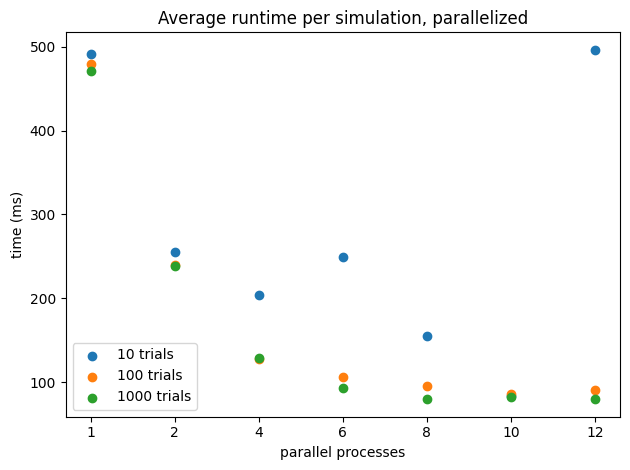

In [3]:
fig, ax = plt.subplots()
ax.set_title('Average runtime per simulation, parallelized')
ax.set_xlabel('parallel processes')
ax.set_ylabel('time (ms)')
x_axis = range(len(procs))
ax.set_xticks(x_axis, procs)
ax.scatter(x_axis, avg_10, label="10 trials")
ax.scatter(x_axis, avg_100, label="100 trials")
ax.scatter(x_axis, avg_1000, label="1000 trials")
ax.legend()
fig.tight_layout()
plt.show()

Running only 10 trials, we get a lot of noise likely due to the fact that the overhead of handling child processes is around the same order of magnitude as actual simulation processing time, as well as interference from other activity on the machine. And at high numbers of processes we actually reverse gains from running in parallel.

Running 100 and 1,000 tasks however, we see a roughly exponential speed-up by engaging more cores until we hit eight, the number of cores on the machine. Adding more processes past this point definitely does not improve performance. Interestingly, the penalty from the extra overhead is still pretty low. I suspect if we kept going (say 64 processes) we'd see the price of overhead.

In [4]:
print(1000 * run(8, 100) / 100)
print(1000 * run(64, 100) / 100)

93.2980034999855
222.82322790000762


Yeah! Like that.